In [13]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from xgboost import plot_importance
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [2]:
## PULL Functions from custom functions
from custom_functions import bertopic_addons as cfc

## you will need to change the name below
currenttable = 'topified_vectorized_Science1900_2023'
aws_dfs = cfc.pull_aws_sql_database(currenttable)

Step 1/7: Loading the dataset ...


In [11]:
aws_dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53833 entries, 0 to 53832
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   paperId                   53833 non-null  object        
 1   externalIds               53833 non-null  object        
 2   publicationVenue          53833 non-null  object        
 3   title                     53833 non-null  object        
 4   abstract                  53833 non-null  object        
 5   year                      53833 non-null  datetime64[ns]
 6   referenceCount            53833 non-null  object        
 7   citationCount             53833 non-null  int32         
 8   influentialCitationCount  53833 non-null  object        
 9   fieldsOfStudy             53833 non-null  object        
 10  s2FieldsOfStudy           53833 non-null  object        
 11  publicationTypes          53833 non-null  object        
 12  publicationDate   

In [8]:
aws_dfs.columns

Index(['paperId', 'externalIds', 'publicationVenue', 'title', 'abstract',
       'year', 'referenceCount', 'citationCount', 'influentialCitationCount',
       'fieldsOfStudy', 's2FieldsOfStudy', 'publicationTypes',
       'publicationDate', 'title_abstract', 'topic_code', 'topic_list',
       'x_vector', 'y_vector', 'z_vector'],
      dtype='object')

Yearly groupby:

Root Mean Squared Error (RMSE): 2933.8381670828558


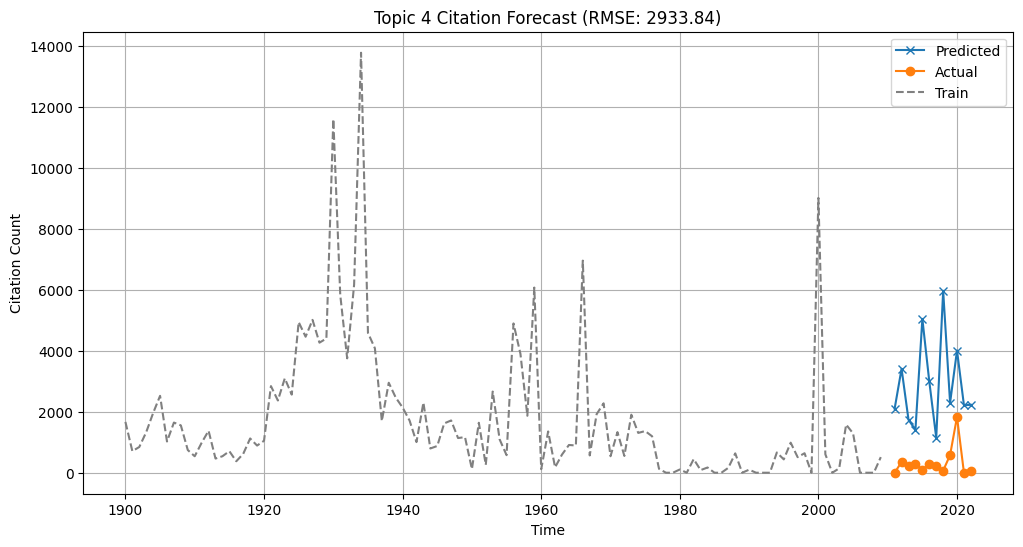

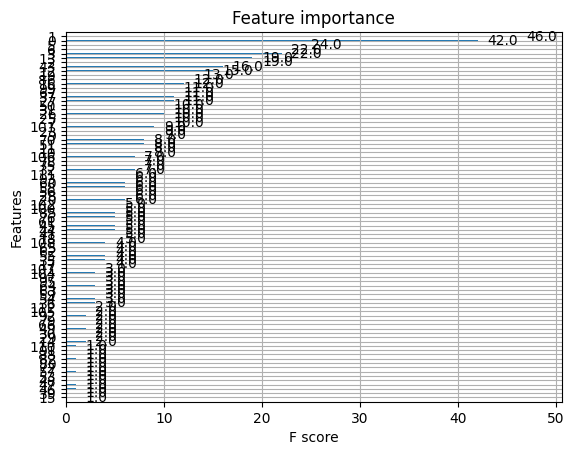

In [18]:
def plot_bertopic_data(topic_number):
    # Group by "Topic" and "Timestamp" and aggregate "citation count"
    ## you can change this to all topics 
    aws1_dfs= aws_dfs
    aws1_dfs['topic_code'] = pd.to_numeric(aws1_dfs['topic_code'], downcast='integer')
    aws1_dfs['citationCount'] = pd.to_numeric(aws1_dfs['citationCount'], downcast='integer')
    aws1_dfs['year'] = pd.to_datetime(aws1_dfs['year'], format='%Y')
    aws1_dfs= aws1_dfs[aws1_dfs['topic_code']!=-1]

    ## code to change the date time, for the moment use year
    grouped_df = aws1_dfs.groupby(['topic_code', 'year'])['citationCount'].sum().reset_index()

    pivot_df = grouped_df.pivot(index='year', columns='topic_code', values='citationCount')

    pivot_df.fillna(0, inplace=True)
    pivot_df = pivot_df.reset_index()

    # Separating the training set and testing set
    train_data=pivot_df[pivot_df['year'].dt.year<2011].reset_index(drop = True)
    test_data=pivot_df[pivot_df['year'].dt.year>2010].reset_index(drop = True)

    # Define the target column (Topic you want to forecast)
    target_topic = topic_number  # Change this to the Topic you want to forecast

    # Prepare the training and testing data
    X_train = train_data.drop(target_topic, axis=1)
    
    
    y_train = train_data[target_topic]  # Shift by 1 to align with next year's frequency
    
    X_test = test_data.drop(target_topic, axis=1)
    
    y_test = test_data[target_topic]

    # Shift the target column to align with next year's frequency
    y_train = train_data[target_topic].shift(-1).dropna()
    y_test = test_data[target_topic].shift(-1).dropna()

    # Exclude the 'YearMonth' column from the training and testing data
    X_train = train_data.drop(columns=['year', target_topic]).iloc[:-1]
    X_test = test_data.drop(columns=['year', target_topic]).iloc[:-1]

    # Create an XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)


    # Create a DataFrame with YearMonth and the predicted values
    y_pred_df = pd.DataFrame({'year': test_data['year'].iloc[:-1], 'Predicted': y_pred})

    # Merge the predicted DataFrame with the original test_data DataFrame
    merged_data = pd.merge(y_pred_df, test_data, on='year')

    # Calculate the root mean squared error (RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Plot the predicted vs. actual values along with y_train
    plt.figure(figsize=(12, 6))
    plt.plot(merged_data['year'], merged_data['Predicted'], label='Predicted', marker='x')
    plt.plot(merged_data['year'], merged_data[target_topic], label='Actual', marker='o')
    plt.plot(train_data['year'].iloc[:-1], y_train, label='Train', linestyle='--', color='gray')
    plt.xlabel('Time')
    plt.ylabel('Citation Count')
    plt.title(f'Topic {target_topic} Citation Forecast (RMSE: {rmse:.2f})')
    plt.legend()
    plt.grid(True)

    # Feature importance plot (optional)
    plot_importance(model)
    plt.show()
    
plot_bertopic_data(4)

Monthly groupby:

Root Mean Squared Error (RMSE): 253.3777771942794


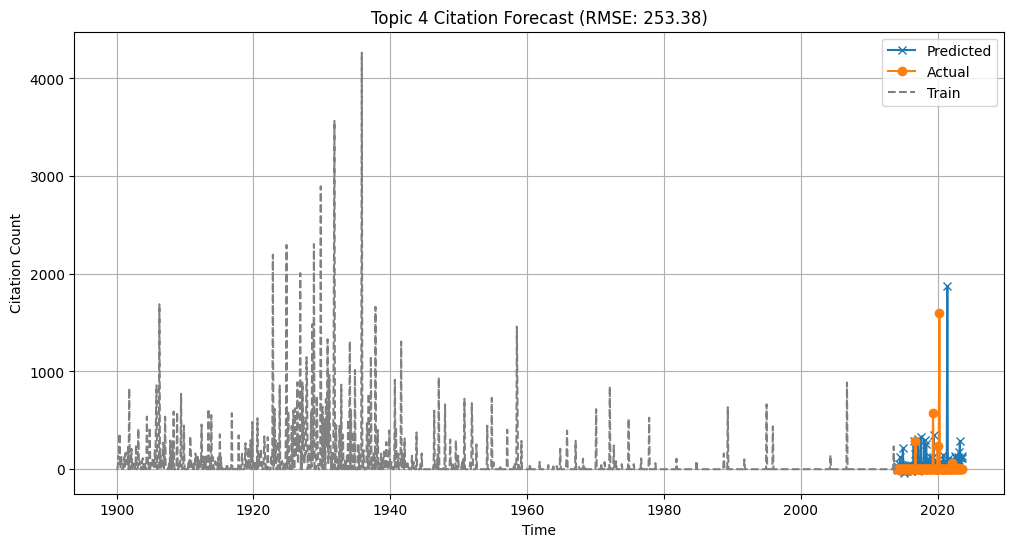

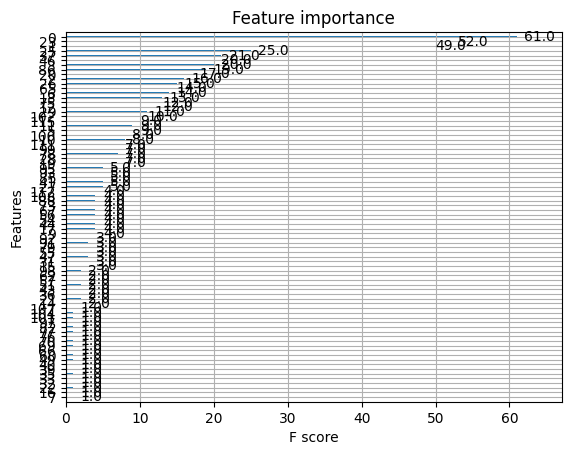

In [17]:
def plot_bertopic_data(topic_number):
    aws1_dfs = aws_dfs[['publicationDate', 'topic_code', 'citationCount', 'influentialCitationCount', 'topic_list']]
    aws1_dfs['topic_code'] = pd.to_numeric(aws1_dfs['topic_code'], downcast='integer')
    aws1_dfs['citationCount'] = pd.to_numeric(aws1_dfs['citationCount'], downcast='integer')
    aws1_dfs = aws1_dfs[aws1_dfs['topic_code'] != -1]
    aws1_dfs = aws1_dfs.replace({None: np.nan})
    aws1_dfs = aws1_dfs.dropna(subset=['publicationDate'])  # Drop rows with missing publicationDate
    aws1_dfs['publicationDate'] = pd.to_datetime(aws1_dfs['publicationDate'], errors='coerce')  # Use 'coerce' to handle incorrect dates
    aws1_dfs['year_month'] = aws1_dfs['publicationDate'].dt.strftime('%Y-%m')
    aws1_dfs['year_month'] = pd.to_datetime(aws1_dfs['year_month'], format='%Y-%m')

    grouped_df = aws1_dfs.groupby(['topic_code', 'year_month'])['citationCount'].sum().reset_index()

    pivot_df = grouped_df.pivot(index='year_month', columns='topic_code', values='citationCount')

    pivot_df.fillna(0, inplace=True)
    pivot_df = pivot_df.reset_index()

    # Separating the training set and testing set
    train_data = pivot_df[pivot_df['year_month'].dt.year < 2014].reset_index(drop=True)
    test_data = pivot_df[pivot_df['year_month'].dt.year > 2013].reset_index(drop=True)

    # Define the target column (Topic you want to forecast)
    target_topic = topic_number  # Change this to the Topic you want to forecast

    # Prepare the training and testing data
    X_train = train_data.drop(target_topic, axis=1)
    y_train = train_data[target_topic].shift(-1).dropna()
    X_test = test_data.drop(target_topic, axis=1)
    y_test = test_data[target_topic].shift(-1).dropna()

     # Exclude the 'YearMonth' column from the training and testing data
    X_train = train_data.drop(columns=['year_month', target_topic]).iloc[:-1]
    X_test = test_data.drop(columns=['year_month', target_topic]).iloc[:-1]

    # Create an XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Create a DataFrame with YearMonth and the predicted values
    y_pred_df = pd.DataFrame({'year_month': test_data['year_month'].iloc[:-1], 'Predicted': y_pred})

    # Merge the predicted DataFrame with the original test_data DataFrame
    merged_data = pd.merge(y_pred_df, test_data, on='year_month')

    # Calculate the root mean squared error (RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Plot the predicted vs. actual values along with y_train
    plt.figure(figsize=(12, 6))
    plt.plot(merged_data['year_month'], merged_data['Predicted'], label='Predicted', marker='x')
    plt.plot(merged_data['year_month'], merged_data[target_topic], label='Actual', marker='o')
    plt.plot(train_data['year_month'].iloc[:-1], y_train, label='Train', linestyle='--', color='gray')
    plt.xlabel('Time')
    plt.ylabel('Citation Count')
    plt.title(f'Topic {target_topic} Citation Forecast (RMSE: {rmse:.2f})')
    plt.legend()
    plt.grid(True)

    # Feature importance plot (optional)
    plot_importance(model)
    plt.show()

plot_bertopic_data(4)



## Future forecasting:

In [294]:
def plot_bertopic_data_into_future(topic_number, future_years):

    # Group by "Topic" and "Timestamp" and aggregate "citation count"
    ## you can change this to all topics 
    aws1_dfs= aws_dfs
    aws1_dfs['topic_code'] = pd.to_numeric(aws1_dfs['topic_code'], downcast='integer')
    aws1_dfs['citationCount'] = pd.to_numeric(aws1_dfs['citationCount'], downcast='integer')
    aws1_dfs['year'] = pd.to_datetime(aws1_dfs['year'], format='%Y')
    aws1_dfs= aws1_dfs[aws1_dfs['topic_code']!=-1]

    ## code to change the date time, for the moment use year
    grouped_df = aws1_dfs.groupby(['topic_code', 'year'])['citationCount'].sum().reset_index()

    pivot_df = grouped_df.pivot(index='year', columns='topic_code', values='citationCount')

    pivot_df.fillna(0, inplace=True)
    pivot_df = pivot_df.reset_index()

    # Define the target column (Topic you want to forecast)
    target_topic = topic_number  # Change this to the Topic you want to forecast

    ## number of years into the future you can forecast
    n = future_years

    # Dropping last n rows using drop
    target_column = pivot_df[target_topic]

    # forget about the lost values
    ## dropped the oldest columns
    target_column.drop(target_column.head(n).index, inplace = True)

    ## pivot_df['year'] + pd.offsets.DateOffset(years=5)
    untarget_columns = pivot_df.drop(target_topic, axis=1)


    ## keep this for later -- these are your forecasting columns 
    X_forecasting_data = untarget_columns.tail(n)
    X_forecasting_years = untarget_columns['year'].tail(n) + pd.offsets.DateOffset(years=n)
    X_forecasting_data['year'] = X_forecasting_years
    X_forecasting = X_forecasting_data.drop(columns=['year'])

    ##  drop the columns you keep for forecasting
    untarget_columns.drop(target_column.tail(n).index, inplace = True)

    df = pd.concat([untarget_columns, target_column.reset_index(drop=True)], axis=1)

    ## shift the prediction of each year
    df['year'] = df['year'] + pd.offsets.DateOffset(years=n)

    pivot_df = df

    # Separating the training set and testing set
    train_data=pivot_df[pivot_df['year'].dt.year<2011].reset_index(drop = True)
    test_data=pivot_df[pivot_df['year'].dt.year>2010].reset_index(drop = True)

    # Prepare the training and testing data
    X_train = train_data.drop(target_topic, axis=1)
    X_test = test_data.drop(target_topic, axis=1)

    # Shift the target column to align with next year's frequency
    y_train = train_data[target_topic].shift(-1).dropna()
    y_test = test_data[target_topic].shift(-1).dropna()

    # Exclude the 'YearMonth' column from the training and testing data
    X_train = train_data.drop(columns=['year', target_topic]).iloc[:-1]
    X_test = test_data.drop(columns=['year', target_topic]).iloc[:-1]

    # Create an XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    y_forecasting = model.predict(X_forecasting)

    # Create a DataFrame with YearMonth and the predicted values
    y_pred_df = pd.DataFrame({'year': test_data['year'].iloc[:-1], 'Predicted': y_pred})
    y_fore_df = pd.DataFrame({'year': X_forecasting_years, 'Forecasted': y_forecasting})

    # Merge the predicted DataFrame with the original test_data DataFrame
    merged_data = pd.merge(y_pred_df, test_data, on='year')
    merged_forecasted_data = pd.merge(y_fore_df, X_forecasting_data, on='year')

    #print(merged_forecasted_data)
    # Calculate the root mean squared error (RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    #print(f"Root Mean Squared Error (RMSE): {rmse}")
    
    y_actual_test_df = test_data[['year',target_topic]]
    y_actual_train_df = train_data[['year',target_topic]]
    y_fore_df =y_fore_df.rename(columns={'Forecasted': target_topic})
    y_pred_df =y_pred_df.rename(columns={'Predicted': target_topic})

    y_actual_test_df['value'] = 'Actual_Test'
    y_actual_train_df['value'] = 'Actual_Train'
    y_fore_df['value'] = 'Forecasted'
    y_pred_df['value'] = 'Predicted_Test'

    final_data = pd.concat([y_actual_test_df,y_actual_train_df,y_fore_df,y_pred_df], axis=0)
    final_data =final_data.rename(columns={target_topic: 'citationCount'})
    final_data['topic_code'] = target_topic
    final_data['RMSE'] = rmse
    return final_data

    """# Plot the predicted vs. actual values along with y_train
    plt.figure(figsize=(12, 6))
    plt.plot(merged_data['year'], merged_data['Predicted'], label='Predicted', marker='x')
    plt.plot(merged_data['year'], merged_data[target_topic], label='Actual', marker='o')
    plt.plot(train_data['year'].iloc[:-1], y_train, label='Train', linestyle='--', color='gray')
    plt.plot(merged_forecasted_data['year'], merged_forecasted_data['Forecasted'], label='Forecasted', marker='+')
    
    plt.xlabel('Time')
    plt.ylabel('Citation Count')
    plt.title(f'Topic {target_topic} Citation Forecast (RMSE: {rmse:.2f})')
    plt.legend()
    plt.grid(True)

    # Feature importance plot (optional)
    plot_importance(model)
    plt.show()"""
    

In [329]:
## create an ordered list of topic codes 
topic_code_list = list(set(aws1_dfs['topic_code'].unique()))

## create a dataframe to concat later 
growing_df = pd.DataFrame()

## for loop through the topic code list 
for i in topic_code_list:
    current_df = plot_bertopic_data_into_future(i, 10)
    growing_df = pd.concat([current_df, growing_df]) 
    
## reset the index and drop the inxiex column 
growing_df = growing_df.reset_index().drop('index',axis=1)

## match the topic code to the topic description 
topic_codes = aws1_dfs[['topic_code','topic_list']].drop_duplicates().reset_index().drop('index',axis=1)

## merge the topics descriptions to the data set
full_datase= growing_df.merge(topic_codes, on='topic_code')

In [330]:
full_datase

,year,citationCount,value,topic_code,RMSE,topic_list
0,2011-01-01,1270.000000,Actual_Test,117,361.497340,117_multiple sclerosis_sclerosis_multiple_axonal
1,2012-01-01,661.000000,Actual_Test,117,361.497340,117_multiple sclerosis_sclerosis_multiple_axonal
2,2013-01-01,163.000000,Actual_Test,117,361.497340,117_multiple sclerosis_sclerosis_multiple_axonal
3,2014-01-01,158.000000,Actual_Test,117,361.497340,117_multiple sclerosis_sclerosis_multiple_axonal
4,2015-01-01,0.000000,Actual_Test,117,361.497340,117_multiple sclerosis_sclerosis_multiple_axonal
...,...,...,...,...,...,...
16043,2018-01-01,30329.228516,Predicted_Test,0,21373.182089,0_species_soil_plant_plants
16044,2019-01-01,30251.216797,Predicted_Test,0,21373.182089,0_species_soil_plant_plants
16045,2020-01-01,31789.476562,Predicted_Test,0,21373.182089,0_species_soil_plant_plants
16046,2021-01-01,31939.412109,Predicted_Test,0,21373.182089,0_species_soil_plant_plants


In [291]:
pd.DataFrame(y_pred)
pd.DataFrame(y_test)
pd.DataFrame(y_forecasting)
pd.DataFrame(y_train)

y_actual_test_df = test_data[['year',target_topic]]
y_actual_train_df = train_data[['year',target_topic]]
y_fore_df =y_fore_df.rename(columns={'Forecasted': target_topic})
y_pred_df =y_pred_df.rename(columns={'Predicted': target_topic})

y_actual_test_df['value'] = 'Actual_Test'
y_actual_train_df['value'] = 'Actual_Train'
y_fore_df['value'] = 'Forecasted'
y_pred_df['value'] = 'Predicted_Test'

final_data = pd.concat([y_actual_test_df,y_actual_train_df,y_fore_df,y_pred_df], axis=0)
final_data =final_data.rename(columns={target_topic: 'citationCount'})
final_data['topic_code'] = target_topic
final_data

,year,citationCount,value,topic_code
0,2011-01-01,3786.000000,Actual_Test,15
1,2012-01-01,17875.000000,Actual_Test,15
2,2013-01-01,7168.000000,Actual_Test,15
3,2014-01-01,17539.000000,Actual_Test,15
4,2015-01-01,5252.000000,Actual_Test,15
...,...,...,...,...
7,2018-01-01,1985.367676,Predicted_Test,15
8,2019-01-01,1368.499878,Predicted_Test,15
9,2020-01-01,3276.970215,Predicted_Test,15
10,2021-01-01,1702.508179,Predicted_Test,15
